In [443]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from scipy.spatial.distance import pdist
import torch.optim as optim

from matplotlib.lines import Line2D  # Import Line2D for custom legend

from torch.optim.lr_scheduler import ReduceLROnPlateau


We moved all the useful functions from the previous assignments to a separate file utils.py. You can simply import them with the following line. Feel free to add additional functions or modify the existing ones!

In [444]:
from utils import MLP, split_data, Dataset, train

In [445]:
# check if a GPU is available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [446]:
molecule = np.array(
    [
        [0.702581, 1.820873],
        [0.702581, 0.296325],
        [-0.702581, -0.296325],
        [-0.702581, -1.820873],
    ]
)

n_atoms = molecule.shape[0]
n_dimensions = molecule.shape[1]

print(
    f"Number of particles: {n_atoms} \nNumber of spatial dimensions: {n_dimensions}",
)

Number of particles: 4 
Number of spatial dimensions: 2


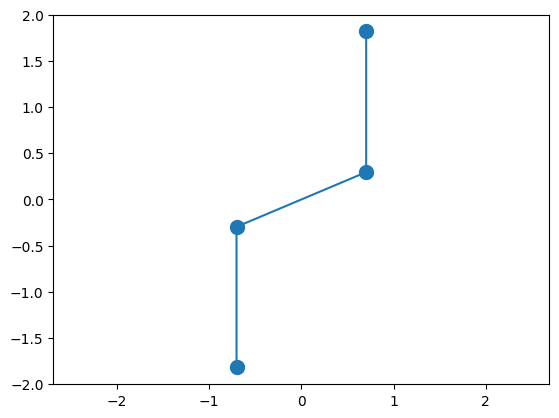

In [447]:
plt.plot(molecule[:, 0], molecule[:, 1], "o-", markersize=10)
plt.axis("equal")

plt.show()

In [448]:
n_samples = 5000
mean = 0
standard_dev = 0.1
noise = np.random.normal(
                 size=(n_samples, n_atoms, n_dimensions),
                 loc=mean, 
                 scale = standard_dev,
)

noised_molecules = noise + molecule
noised_molecules

array([[[ 0.65560622,  1.63321604],
        [ 0.78926495,  0.27010888],
        [-0.66733718, -0.32808455],
        [-0.56675828, -1.88507164]],

       [[ 0.63381225,  1.79935144],
        [ 0.80240734,  0.21366554],
        [-0.66857205, -0.12855189],
        [-0.81521408, -1.95483112]],

       [[ 0.52356514,  1.75439767],
        [ 0.64859557,  0.32807228],
        [-0.698901  , -0.27134974],
        [-0.81538982, -1.83976634]],

       ...,

       [[ 0.79426198,  1.66532427],
        [ 0.67490398,  0.2589211 ],
        [-0.81091189, -0.28658558],
        [-0.79467499, -1.79559999]],

       [[ 0.75862887,  1.7743751 ],
        [ 0.65087842,  0.45174182],
        [-0.81224551, -0.35346318],
        [-0.71354079, -1.77896813]],

       [[ 0.7265351 ,  1.61263618],
        [ 0.62434767,  0.09797515],
        [-0.63029832, -0.30589304],
        [-0.76351867, -1.77797732]]])

In [ ]:
def plot_mollies(mollies, title="Molecules with Noise"):
  labeled = False
  alpha = 50 / n_samples
  for mol in mollies:
    if not labeled:
      plt.plot(mol[:, 0], mol[:, 1], "o-", markersize=10, c="Blue", alpha=alpha, 
              label=f"Probability cloud of molecule with: \n\t{n_samples} samples, \n\tmean: {mean}, \n\tstandard deviation: {standard_dev}")
      labeled = True
    else:
      plt.plot(mol[:, 0], mol[:, 1], "o-", markersize=10, c="Blue", alpha=alpha)

  legend_handle = Line2D([0], [0], marker='o', color='blue', markerfacecolor='blue', markersize=10, alpha=.5)  # Higher alpha for legend

  plt.axis("equal")
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title("Molecule with Noise")

  plt.legend([legend_handle], [f"Probability cloud of molecule with \n{n_samples} samples, \nmean: {mean}, \nstandard deviation: {standard_dev}"])


  plt.tight_layout()
  plt.show()

def plot_dataset(my_dataset, title="Molecules with Noise"):
    mollies = [my_dataset[i][0].tolist() for i in range(len(my_dataset)) ]
    # alpha = 50 / n_samples
    plot_mollies(mollies, title)



In [450]:
noised_molecules

array([[[ 0.65560622,  1.63321604],
        [ 0.78926495,  0.27010888],
        [-0.66733718, -0.32808455],
        [-0.56675828, -1.88507164]],

       [[ 0.63381225,  1.79935144],
        [ 0.80240734,  0.21366554],
        [-0.66857205, -0.12855189],
        [-0.81521408, -1.95483112]],

       [[ 0.52356514,  1.75439767],
        [ 0.64859557,  0.32807228],
        [-0.698901  , -0.27134974],
        [-0.81538982, -1.83976634]],

       ...,

       [[ 0.79426198,  1.66532427],
        [ 0.67490398,  0.2589211 ],
        [-0.81091189, -0.28658558],
        [-0.79467499, -1.79559999]],

       [[ 0.75862887,  1.7743751 ],
        [ 0.65087842,  0.45174182],
        [-0.81224551, -0.35346318],
        [-0.71354079, -1.77896813]],

       [[ 0.7265351 ,  1.61263618],
        [ 0.62434767,  0.09797515],
        [-0.63029832, -0.30589304],
        [-0.76351867, -1.77797732]]])

/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_75846/2792646467.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


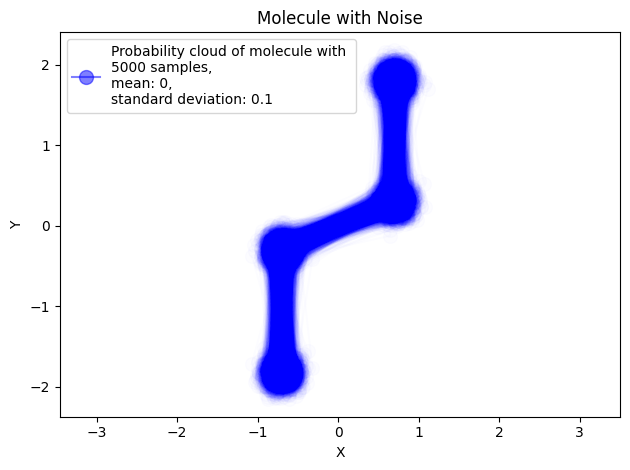

In [451]:
plot_mollies(noised_molecules)

## 1.2 Featurization

Here's an example of how to use pdist:

In [452]:
distances = pdist(molecule)
distances

array([1.524548  , 2.54106427, 3.90343364, 1.52502927, 2.54106427,
       1.524548  ])

We can check that these distances are correct:

In [453]:
# Distance atom 0 - 1
print(f"{np.linalg.norm(molecule[0,:] - molecule[1,:]):.6f}")
# Distance atom 0 - 2
print(f"{np.linalg.norm(molecule[0,:] - molecule[2,:]):.6f}")
# Distance atom 0 - 3
print(f"{np.linalg.norm(molecule[0,:] - molecule[3,:]):.6f}")
# Distance atom 1 - 2
print(f"{np.linalg.norm(molecule[1,:] - molecule[2,:]):.6f}")
# Distance atom 1 - 3
print(f"{np.linalg.norm(molecule[1,:] - molecule[3,:]):.6f}")
# Distance atom 2 - 3
print(f"{np.linalg.norm(molecule[2,:] - molecule[3,:]):.6f}")


1.524548
2.541064
3.903434
1.525029
2.541064
1.524548


In [454]:
flattened_coordinates = [np.reshape(mol, (n_atoms*n_dimensions)) for mol in noised_molecules]
distances = [pdist(mol) for mol in noised_molecules]
potentials = [(1 / dist) for dist in distances]
# potentials
distances


[array([1.36964441, 2.36577244, 3.72458363, 1.5746508 , 2.54629183,
        1.56023233]),
 array([1.59462349, 2.32658894, 4.02412276, 1.51026261, 2.70537924,
        1.83215712]),
 array([1.43179493, 2.36602537, 3.83546807, 1.47480635, 2.61587032,
        1.57273655]),
 array([1.68167884, 2.67511004, 4.13196108, 1.63263574, 2.58042813,
        1.78708834]),
 array([1.52095429, 2.60177202, 3.96346084, 1.67050359, 2.66647008,
        1.52265786]),
 array([1.50159789, 2.45346193, 3.87939094, 1.32723142, 2.48666237,
        1.53447512]),
 array([1.28036745, 2.35950459, 3.88725951, 1.54408179, 2.70974831,
        1.79683556]),
 array([1.60310517, 2.42410643, 3.98794564, 1.25470216, 2.48371878,
        1.69516632]),
 array([1.49950682, 2.54053626, 3.93218208, 1.69597997, 2.72705905,
        1.51164901]),
 array([1.57143047, 2.6275651 , 4.03322337, 1.47024339, 2.58052742,
        1.54902649]),
 array([1.3072918 , 2.38335972, 3.59149419, 1.56789615, 2.44369174,
        1.4178701 ]),
 array([1.

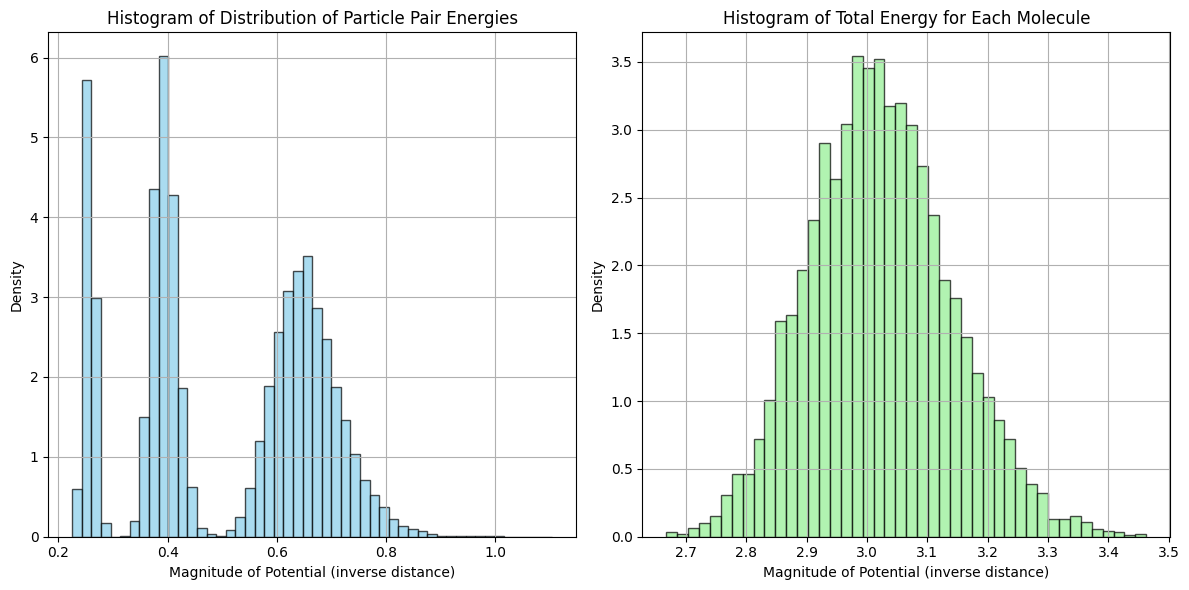

In [455]:
# Create the figure and axes (two subplots side by side)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

pairwise_energies = np.concatenate(potentials)

# Plot the first histogram
ax[0].hist(pairwise_energies, bins='auto', density=True, color='skyblue', edgecolor='black', alpha=0.7)
ax[0].set_title("Histogram of Distribution of Particle Pair Energies")
ax[0].set_xlabel("Magnitude of Potential (inverse distance)")
ax[0].set_ylabel("Density")
ax[0].grid(True)

total_energies = [sum(potential) for potential in potentials]


# Plot the second histogram
ax[1].hist(total_energies, bins='auto', density=True, color='lightgreen', edgecolor='black', alpha=0.7)
ax[1].set_title("Histogram of Total Energy for Each Molecule")
ax[1].set_xlabel("Magnitude of Potential (inverse distance)")
ax[1].set_ylabel("Density")
ax[1].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()



In [456]:
class Data(Dataset):
  """Dataset wrapper. Takes numpy arrays and stores them as torch tensors.
    Data is transformed to the device."""
  def __init__(self, x: np.ndarray,
                y: np.ndarray,
                device: str = DEVICE):
    self.x = torch.from_numpy(x).float().to(device)
    self.y =  torch.from_numpy(y).float().to(device)
    self.len = self.x.shape[0]
  
  def __getitem__(self, index: int) -> tuple:
    return self.x[index].float(), self.y[index].float()
  
  def __len__(self) -> int:
    return self.len

In [457]:
# define fraction of data used for training
train_fraction = .8
n_train = int(train_fraction * n_samples)

# get indices for training and test set
ids = np.arange(n_samples)
np.random.shuffle(ids)
ids_train, ids_test  = map(np.array, np.split(ids, [n_train]))

flattened_coordinates = np.array(flattened_coordinates)
total_energies = np.array(total_energies)
distances = np.array(distances)

# generate datasets for training and testing        
coords_train_data = Data(flattened_coordinates[ids_train], total_energies[ids_train])
coords_test_data = Data(flattened_coordinates[ids_test], total_energies[ids_test])
dists_train_data = Data(distances[ids_train], total_energies[ids_train])
dists_test_data = Data(distances[ids_test], total_energies[ids_test])

In [458]:
distances[ids_train].shape

(4000, 6)

In [459]:
batch_size = 128
coords_train_loader = DataLoader(coords_train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
coord_test_loader = DataLoader(coords_test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

dists_train_loader = DataLoader(dists_train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
dists_test_loader = DataLoader(dists_test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

In [460]:
# import torch
# import torch.nn as nn

# import torch.nn.functional as F
# from torch.utils.data import DataLoader, TensorDataset

# Define the MLP model
class MLPPotentialEstimator(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=1):
        super(MLPPotentialEstimator, self).__init__()
        
        # Create hidden layers dynamically based on the hidden_sizes list
        layers = []
        in_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ELU(alpha=1.0))  # Activation after each hidden layer
            in_size = hidden_size
        
        # The final output layer (no activation, as we want a scalar output)
        layers.append(nn.Linear(in_size, output_size))
        
        # Use nn.Sequential to combine the layers
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    """
    Function to train the model.

    Args:
        model: The model to train.
        train_loader: The DataLoader for the training data.
        criterion: The loss function (e.g., MSELoss).
        optimizer: The optimizer to update weights (e.g., Adam).
        num_epochs: The number of epochs to train.
    """
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()  # Set model to training mode

        # Iterate over the batches in the train_loader
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            
            # Forward pass: get the model's predictions
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass: compute gradients
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            running_loss += loss.item()
            # For regression, no need to compute accuracy, but we can track the loss
            total += labels.size(0)
        
        # Print statistics after each epoch
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        train_losses.append(epoch_loss)
    
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # No need to compute gradients for evaluation
            test_loss = 0.0
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
            
            # Average test loss
            avg_test_loss = test_loss / len(test_loader)
            print(f"Test Loss: {avg_test_loss:.4f}")
            test_losses.append(test_loss)

        model.train()  # Set the model back to training mode for the next epoch

    return train_losses, test_losses


def evaluate_regression_model(model, dataloader, criterion, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        model.to(device)
        model.eval()  # Set the model to evaluation mode

        total_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():  # Disable gradient computation for evaluation
            for batch in dataloader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                all_preds.extend(outputs.cpu().detach().numpy().flatten())  # Flatten output
                all_labels.extend(labels.cpu().detach().numpy().flatten())  # Flatten labels


        # print(type(all_preds))
        # all_preds = np.array(all_preds)
        # all_labels = np.array(all_labels)

        # # Ensure correct data types
        # all_preds = all_preds.astype(np.float64)
        # all_labels = all_labels.astype(np.float64)

        # # Check for NaN or infinite values
        # if np.any(np.isnan(all_preds)) or np.any(np.isnan(all_labels)):
        #     print("NaN values found in predictions or labels.")
        # if np.any(np.isinf(all_preds)) or np.any(np.isinf(all_labels)):
        #     print("Infinite values found in predictions or labels.")

        #  # Debugging the shapes and types
        # print(f"Shape of all_preds: {all_preds.shape}")
        # print(f"Shape of all_labels: {all_labels.shape}")
        # print(f"Type of all_preds: {type(all_preds)}")
        # print(f"Type of all_labels: {type(all_labels)}")

        # Compute metrics
        avg_loss = total_loss / len(dataloader)
        mse = mean_squared_error(all_labels, all_preds)
        mae = mean_absolute_error(all_labels, all_preds)
        r2 = r2_score(all_labels, all_preds)

        return {
            "loss": avg_loss,
            "mse": mse,
            "mae": mae,
            "r2": r2,
        }
    
# def plot_regression_model(model,)
        

In [461]:
mean_squared_error(np.array([1, 2, 3]), np.array([4, 5, 6]))

9.0

In [462]:
# 1. Hyperparameters
coords_input_size = 8  # Example input size (number of features)
dists_input_size = 6
hidden_sizes = [128, 128, 128, 128, 128, 64, 64, 32]  # Number of neurons per hidden layer
output_size = 1  # Single output (potential energy)

coords_model = MLPPotentialEstimator(coords_input_size, hidden_sizes, output_size)
dists_model = MLPPotentialEstimator(dists_input_size, hidden_sizes, output_size)


criterion = nn.MSELoss()
dists_criterion = nn.MSELoss()
coords_optimizer = optim.SGD(coords_model.parameters(), lr=0.001)
dists_optimizer = optim.SGD(dists_model.parameters(), lr=.001)
scheduler = ReduceLROnPlateau(coords_optimizer, 'min', patience=5, factor=0.5, verbose=True)






/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [463]:
num_epochs = 100
coords_train_losses, coords_test_losses = train_model(coords_model, coords_train_loader, coord_test_loader, criterion, coords_optimizer, num_epochs)

/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torc

Epoch [1/100], Loss: 7.5051
Test Loss: 6.5912
Epoch [2/100], Loss: 5.9075
Test Loss: 5.1131
Epoch [3/100], Loss: 4.4998
Test Loss: 3.7882
Epoch [4/100], Loss: 3.2331
Test Loss: 2.5936
Epoch [5/100], Loss: 2.1069
Test Loss: 1.5705
Epoch [6/100], Loss: 1.1930
Test Loss: 0.7991
Epoch [7/100], Loss: 0.5627
Test Loss: 0.3277
Epoch [8/100], Loss: 0.2159
Test Loss: 0.1126
Epoch [9/100], Loss: 0.0744
Test Loss: 0.0383
Epoch [10/100], Loss: 0.0296
Test Loss: 0.0184
Epoch [11/100], Loss: 0.0174
Test Loss: 0.0142
Epoch [12/100], Loss: 0.0148
Test Loss: 0.0135
Epoch [13/100], Loss: 0.0141
Test Loss: 0.0135
Epoch [14/100], Loss: 0.0140
Test Loss: 0.0135
Epoch [15/100], Loss: 0.0141
Test Loss: 0.0135
Epoch [16/100], Loss: 0.0139
Test Loss: 0.0135
Epoch [17/100], Loss: 0.0140
Test Loss: 0.0136
Epoch [18/100], Loss: 0.0140
Test Loss: 0.0136
Epoch [19/100], Loss: 0.0141
Test Loss: 0.0136
Epoch [20/100], Loss: 0.0139
Test Loss: 0.0135
Epoch [21/100], Loss: 0.0140
Test Loss: 0.0135
Epoch [22/100], Loss: 

In [464]:
dists_num_epochs = 50
dists_train_losses, dists_test_losses = train_model(dists_model, dists_train_loader, dists_test_loader, dists_criterion, dists_optimizer, dists_num_epochs)


Epoch [1/50], Loss: 8.2980
Test Loss: 7.0452
Epoch [2/50], Loss: 6.0094
Test Loss: 4.8042
Epoch [3/50], Loss: 3.7132
Test Loss: 2.4685
Epoch [4/50], Loss: 1.4878
Test Loss: 0.5925
Epoch [5/50], Loss: 0.2495
Test Loss: 0.0510
Epoch [6/50], Loss: 0.0273
Test Loss: 0.0145
Epoch [7/50], Loss: 0.0149
Test Loss: 0.0138
Epoch [8/50], Loss: 0.0144
Test Loss: 0.0140
Epoch [9/50], Loss: 0.0144
Test Loss: 0.0139
Epoch [10/50], Loss: 0.0145
Test Loss: 0.0140
Epoch [11/50], Loss: 0.0144
Test Loss: 0.0139
Epoch [12/50], Loss: 0.0142
Test Loss: 0.0139
Epoch [13/50], Loss: 0.0144
Test Loss: 0.0139
Epoch [14/50], Loss: 0.0144
Test Loss: 0.0140
Epoch [15/50], Loss: 0.0144
Test Loss: 0.0139
Epoch [16/50], Loss: 0.0144
Test Loss: 0.0139
Epoch [17/50], Loss: 0.0143
Test Loss: 0.0139
Epoch [18/50], Loss: 0.0144
Test Loss: 0.0139
Epoch [19/50], Loss: 0.0143
Test Loss: 0.0140
Epoch [20/50], Loss: 0.0144
Test Loss: 0.0140
Epoch [21/50], Loss: 0.0143
Test Loss: 0.0140
Epoch [22/50], Loss: 0.0144
Test Loss: 0.01

In [465]:
distances

array([[1.36964441, 2.36577244, 3.72458363, 1.5746508 , 2.54629183,
        1.56023233],
       [1.59462349, 2.32658894, 4.02412276, 1.51026261, 2.70537924,
        1.83215712],
       [1.43179493, 2.36602537, 3.83546807, 1.47480635, 2.61587032,
        1.57273655],
       ...,
       [1.4114589 , 2.52715951, 3.80824335, 1.58279068, 2.52600856,
        1.50910176],
       [1.32701505, 2.6448709 , 3.84623603, 1.67005591, 2.61490089,
        1.42891811],
       [1.51810418, 2.34984069, 3.70358207, 1.31804632, 2.3335318 ,
        1.47810006]])

In [466]:
dists_test_losses

[56.3616886138916,
 38.433860778808594,
 19.74820327758789,
 4.740217924118042,
 0.4076254814863205,
 0.11582867801189423,
 0.11003019940108061,
 0.11204147431999445,
 0.11128372978419065,
 0.11193252447992563,
 0.1114644380286336,
 0.1114109605550766,
 0.11154816951602697,
 0.11160807497799397,
 0.11110773589462042,
 0.1113764913752675,
 0.11111772153526545,
 0.11136834416538477,
 0.1118800351396203,
 0.11161571647971869,
 0.11215965822339058,
 0.11098328884691,
 0.11123526003211737,
 0.1117597883567214,
 0.11215681303292513,
 0.11178918555378914,
 0.1113786743953824,
 0.11188297253102064,
 0.11104707606136799,
 0.11143591534346342,
 0.11092086881399155,
 0.11148162465542555,
 0.11123624071478844,
 0.11180380918085575,
 0.1114202830940485,
 0.11171447671949863,
 0.1110924780368805,
 0.11159375216811895,
 0.11081588920205832,
 0.11029642261564732,
 0.1112179970368743,
 0.11191130056977272,
 0.1113084526732564,
 0.11199284344911575,
 0.1114996774122119,
 0.11160005908459425,
 0.11112971

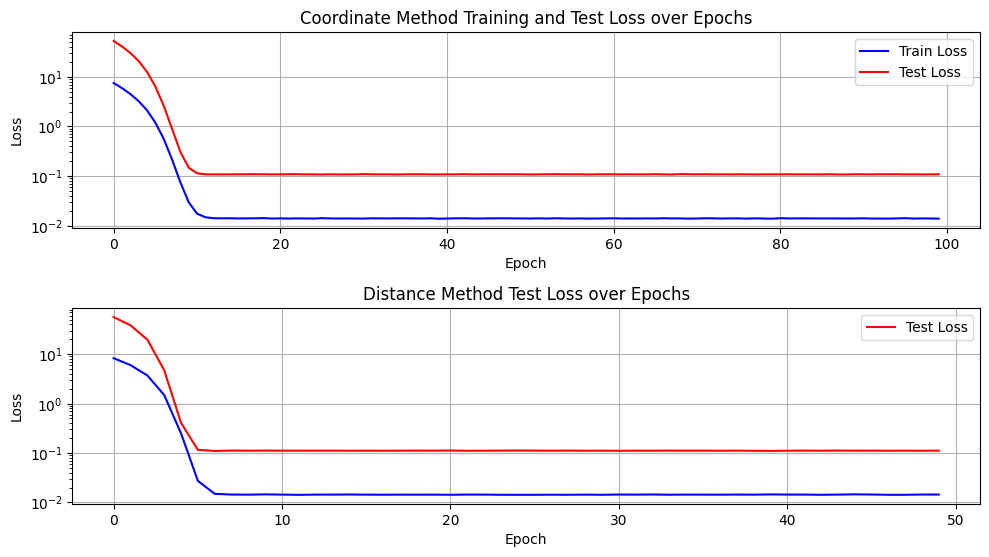

In [467]:
plt.figure(figsize=(10, 8))

# First subplot (top)
plt.subplot(3, 1, 1)  
plt.plot(range(len(coords_train_losses)), coords_train_losses, label="Train Loss", color="blue")
plt.plot(range(len(coords_test_losses)), coords_test_losses, label="Test Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Coordinate Method Training and Test Loss over Epochs")
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(3, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(range(len(dists_test_losses)), dists_test_losses, label="Test Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Distance Method Test Loss over Epochs")
plt.legend()
plt.yscale('log')
plt.grid(True)

# plt.subplot(3, 1, 3)  # 2 rows, 1 column, second subplot
plt.plot(range(len(dists_train_losses)), dists_train_losses, label="Train Loss", color="blue")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Distance Method Training Loss over Epochs")
# plt.legend()
# plt.yscale('log')
# plt.grid(True)


plt.tight_layout()

plt.show()

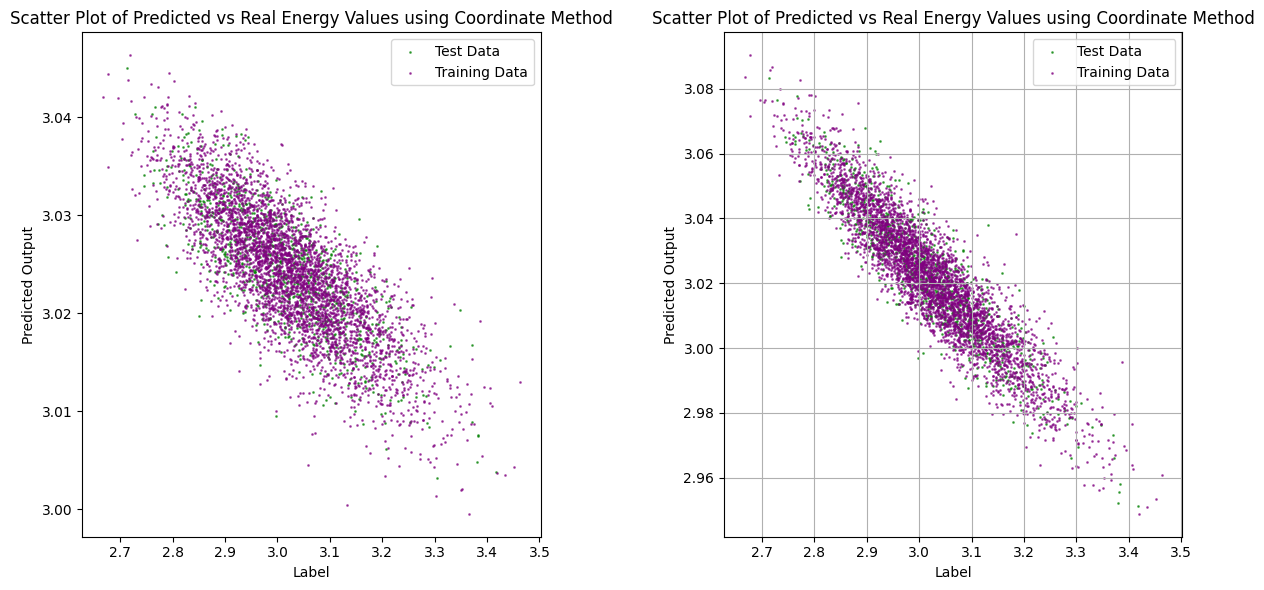

In [468]:
with torch.no_grad():
  coords_test_pred = []
  coords_test_real = []
  coords_train_pred = []
  coords_train_real = []

  dists_test_pred = []
  dists_test_real = []
  dists_train_pred = []
  dists_train_real = []

  for inputs, label in coords_test_data:
    output = coords_model(inputs)
    coords_test_pred.append(output) 
    coords_test_real.append(label)

  for inputs, label in coords_train_data:
    output = coords_model(inputs)
    coords_train_pred.append(output) 
    coords_train_real.append(label)
  
  for inputs, label in dists_test_data:
    output = dists_model(inputs)
    dists_test_pred.append(output) 
    dists_test_real.append(label)

  for inputs, label in dists_train_data:
    output = dists_model(inputs)
    dists_train_pred.append(output) 
    dists_train_real.append(label)
    
  # print(len(coords_input))
  # print(len(coords_test_pred))

  # len(coords_test_data)
  # coords_test_data[0]

  # test_coords = coords_test_data[:,0]
  # test_labels = coords_test_data[:,1]
  # train_coords = coords_train_data[:,0]
  # train_labels = coords_train_data[:,1] 

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # 1 row, 2 columns
  ax1, ax2 = axes
  # plt.figure(figsize=(10, 6))

  # Scatter plot for predicted values
  ax1.scatter(coords_test_real, coords_test_pred, color='green', alpha=0.6, label='Test Data', s=1)
  ax1.scatter(coords_train_real, coords_train_pred, color='purple', alpha=0.6, label='Training Data', s=1)

  # Add labels and title
  ax1.set_xlabel('Label')
  ax1.set_ylabel('Predicted Output')
  ax1.set_title('Scatter Plot of Predicted vs Real Energy Values using Coordinate Method')

  ax2.scatter(dists_test_real, dists_test_pred, color='green', alpha=0.6, label='Test Data', s=1)
  ax2.scatter(dists_train_real, dists_train_pred, color='purple', alpha=0.6, label='Training Data', s=1)

  # Add labels and title
  ax2.set_xlabel('Label')
  ax2.set_ylabel('Predicted Output')
  ax2.set_title('Scatter Plot of Predicted vs Real Energy Values using Coordinate Method')


  ax1.legend()
  ax2.legend()

  plt.tight_layout()

  # Show grid for better readability
  plt.grid(True)
  fig.subplots_adjust(wspace=0.4, hspace=0.6)

  # Display the plot
  plt.show()

In [469]:
evaluate_regression_model(coords_model, coord_test_loader, criterion)



{'loss': 0.013519937987439334,
 'mse': 0.014666521,
 'mae': 0.09706286,
 'r2': -0.09689018968045149}

In [470]:
for inputs, label in dists_test_data:
  output = dists_model(inputs)
  print(output)
  dists_test_pred.append(output) 
  dists_test_real.append(label)

# for inputs, label in dists_train_data:
#   output = dists_model(inputs)
#   dists_train_pred.append(output) 
#   dists_train_real.append(label)

tensor([3.0274], grad_fn=<ViewBackward0>)
tensor([3.0377], grad_fn=<ViewBackward0>)
tensor([3.0313], grad_fn=<ViewBackward0>)
tensor([3.0384], grad_fn=<ViewBackward0>)
tensor([3.0501], grad_fn=<ViewBackward0>)
tensor([3.0463], grad_fn=<ViewBackward0>)
tensor([3.0170], grad_fn=<ViewBackward0>)
tensor([3.0450], grad_fn=<ViewBackward0>)
tensor([2.9969], grad_fn=<ViewBackward0>)
tensor([3.0334], grad_fn=<ViewBackward0>)
tensor([3.0163], grad_fn=<ViewBackward0>)
tensor([3.0117], grad_fn=<ViewBackward0>)
tensor([3.0391], grad_fn=<ViewBackward0>)
tensor([3.0099], grad_fn=<ViewBackward0>)
tensor([3.0151], grad_fn=<ViewBackward0>)
tensor([2.9772], grad_fn=<ViewBackward0>)
tensor([3.0361], grad_fn=<ViewBackward0>)
tensor([3.0073], grad_fn=<ViewBackward0>)
tensor([2.9788], grad_fn=<ViewBackward0>)
tensor([3.0452], grad_fn=<ViewBackward0>)
tensor([3.0328], grad_fn=<ViewBackward0>)
tensor([3.0240], grad_fn=<ViewBackward0>)
tensor([3.0375], grad_fn=<ViewBackward0>)
tensor([3.0056], grad_fn=<ViewBack

## 2 Data augmenatation

You can use this function to rotate the samples in your dataset.

In [471]:
def rotate(vector, theta):
    """Rotates a two-dimensional vector by the angle theta."""
    rotMatrix = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )
    return np.matmul(rotMatrix, vector)

This is how you can permute data:

In [472]:
ids = [1,2,3,0]
molecule_permuted = molecule[ids,:]

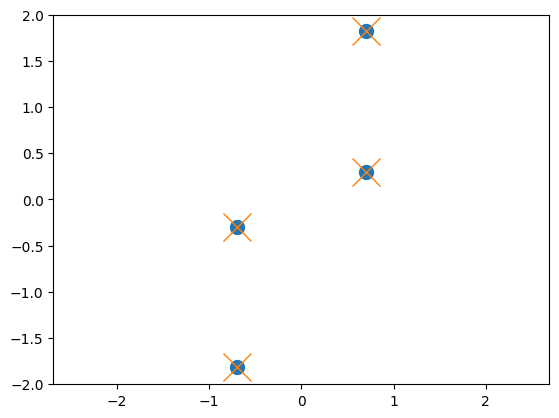

In [473]:
plt.plot(molecule[:, 0], molecule[:, 1], "o", markersize=10)
plt.axis("equal")
plt.plot(molecule_permuted[:, 0], molecule_permuted[:, 1], "x", markersize=20)
plt.axis("equal")

plt.show()

/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_75846/2792646467.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


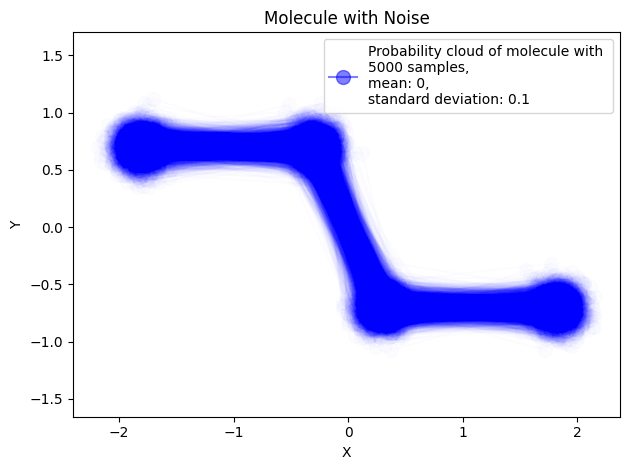

In [474]:
rotated_noised_molecules = [np.transpose(rotate(np.transpose(molly), np.pi / 2)) for molly in noised_molecules]
plot_mollies(rotated_noised_molecules, "Rotated Molecule with Noise")

# noised_molecules[0]

In [475]:
def permute_without_fixed_points(coords):
    n = len(coords)
    while True:
        perm = torch.randperm(n)  # Generate random permutation of indices
        if not torch.all(perm == torch.arange(n)):  # Check for no fixed points
            return coords[perm]  # Apply permutation to the tensor

In [476]:
rotated_flattened_coordinates = [np.reshape(mol, (n_atoms*n_dimensions)) for mol in rotated_noised_molecules]
rotated_distances = [pdist(mol) for mol in noised_molecules]
rotated_potentials = [(1 / dist) for dist in rotated_distances]
rotated_total_energies = [sum(potential) for potential in rotated_potentials]

permutated_rotated_noised_molecules = [permute_without_fixed_points(molly) for molly in rotated_noised_molecules]
permutated_rotated_flattened_coordinates = [np.reshape(mol, (n_atoms*n_dimensions)) for mol in permutated_rotated_noised_molecules]
permutated_rotated_distances = [permute_without_fixed_points(molly) for molly in rotated_distances]

rotated_coords_data = Data(flattened_coordinates, total_energies)
rotated_dists_data = Data(distances, total_energies)
permutated_rotated_coords_data = Data(np.array(permutated_rotated_flattened_coordinates), total_energies)
permutated_rotated_dists_data = Data(np.array(permutated_rotated_distances), total_energies)

batch_size = 128
rotated_coords_loader = DataLoader(rotated_coords_data, 
                         batch_size=batch_size, 
                         shuffle=True)

rotated_dists_loader = DataLoader(rotated_dists_data, 
                         batch_size=batch_size, 
                         shuffle=True)

permutated_rotated_coords_loader = DataLoader(permutated_rotated_coords_data, 
                         batch_size=batch_size, 
                         shuffle=True)

permutated_rotated_dists_loader = DataLoader(permutated_rotated_dists_data, 
                         batch_size=batch_size, 
                         shuffle=True)

print("Rotated coords model: ", evaluate_regression_model(coords_model, rotated_coords_loader, criterion))
print("Rotated distances model: ", evaluate_regression_model(dists_model, rotated_dists_loader, criterion))

print("Permutated rotated coords model: ", evaluate_regression_model(coords_model, permutated_rotated_coords_loader, criterion))
print("Permutated rotated distances model: ", evaluate_regression_model(dists_model, permutated_rotated_dists_loader, criterion))


/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/

Rotated coords model:  {'loss': 0.0139578448375687, 'mse': 0.015094054, 'mae': 0.0978229, 'r2': -0.0929102976603362}
Rotated distances model:  {'loss': 0.0141777946613729, 'mse': 0.018717775, 'mae': 0.10888766, 'r2': -0.35529192347438454}


/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/

Permutated rotated coords model:  {'loss': 0.12160989865660668, 'mse': 0.11985879, 'mae': 0.31952885, 'r2': -7.678577153175738}
Permutated rotated distances model:  {'loss': 0.024111898243427278, 'mse': 0.028168032, 'mae': 0.13354565, 'r2': -1.0395536145012874}


/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [477]:

plot_dataset(permutated_rotated_noised_molecules)


[[0.3280845463188643, -0.6673371782306016], [-0.21366553912020758, 0.8024073393781181], [0.27134974101986814, -0.6989010013008488], [-0.17292864362802945, 0.7563983250639952], [-0.34845846573836015, 0.7415354027231045], [0.3739014966509415, -0.5651147029374979], [1.9624434002473725, -0.6144484894066132], [1.945530318046089, -0.7482913010517475], [0.3386136528085778, -0.6900992506616181], [-1.795141852496086, 0.8563255516884223], [0.2173802632143818, -0.792185450654721], [1.7597047303071542, -0.810755062924172], [1.9223866512905947, -0.6500695799298675], [-1.8004674458689298, 0.7260320382674116], [-0.2815400139662246, 0.8883831350388063], [-0.2841737247957149, 0.6667386693184978], [1.7504388809547642, -0.5243357093440212], [-0.11538663458340494, 0.6464776959200875], [0.18002283488186635, -0.516607959903161], [-0.3853951438720206, 0.6685415097165273], [-1.7032109231277786, 0.6073122539839232], [-0.38445828234996543, 0.8151472807359005], [0.1953969917190107, -0.7549731617379831], [1.81315

In [478]:
plot_dataset(transformed_rotated_coords_dataset)

# x = [transformed_rotated_coords_dataset[i][0] for i in range(len(transformed_rotated_coords_dataset))]
# x

[[0.7135077714920044, 0.3272227346897125, -1.7220841646194458, -0.5785119533538818, 0.7333972454071045, -0.49403101205825806, -0.35715174674987793, 1.9023046493530273], [0.7379853129386902, 1.6613209247589111, -1.6409683227539062, -0.7737607359886169, -0.3207014203071594, 0.7665284872055054, 0.28190529346466064, -0.764580488204956], [-1.8077876567840576, -0.7135567665100098, 0.6239916682243347, 1.793405532836914, 0.8413110971450806, 0.3044394254684448, -0.8461195230484009, -0.15335239470005035], [-0.32345977425575256, -0.7049320340156555, -0.7084013819694519, 0.7255263924598694, 1.9213114976882935, 0.7626760601997375, 0.37516722083091736, -1.752785325050354], [-0.2525317668914795, 0.2628786563873291, 1.8715523481369019, 0.9786493182182312, -1.8489999771118164, -0.750759482383728, -0.8487152457237244, 0.8008973002433777], [-1.769491195678711, 0.49451154470443726, 1.7891335487365723, -0.48137322068214417, 0.5797942280769348, -0.006503719370812178, -0.8111949563026428, -0.3184441328048706